# Overview of supervised classification algorithms

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Dataset
For the examples, we are going to use the [**Recipe Ingredients Dataset**](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset).

Each recipe is a collection of ingredients and the task is to guess the kind of cuisine (multi-class classification).

First, we compute some statistics on the dataset in order to find the most specific ingredients for each type of cuisine.

In [2]:
import json
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
train_data_file = "/Users/flint/Data/recipe/kaggle_recipes/train.json"
with open(train_data_file, 'r') as infile:
    train_json = json.load(infile)

In [4]:
def to_count_df(data, vectorizer, fit=True):
    y = [x['cuisine'] for x in data]
    documents = [x['ingredients'] for x in data]
    if fit:
        X = vectorizer.fit_transform(documents)
    else:
        X = vectorizer.transform(documents)
    return X, np.array(y)

In [5]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, token_pattern=None, lowercase=False, min_df=10)
X, y = to_count_df(train_json, vectorizer, fit=True)

In [6]:
X.shape

(39774, 2400)

### (optional) Simplify target

In [7]:
catmap = {'cajun_creole': 'usa', 'chinese': 'asian', 'filipino': 'asian', 
          'southern_us': 'usa', 'japanese': 'asian', 'korean': 'asian', 'thai': 'asian', 'vietnamese': 'asian'}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

## Use LDA to reduce the dimensionality

In [9]:
from sklearn.decomposition import LatentDirichletAllocation

## Visualize the problem

In [10]:
import matplotlib.pyplot as plt

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X_train.toarray())

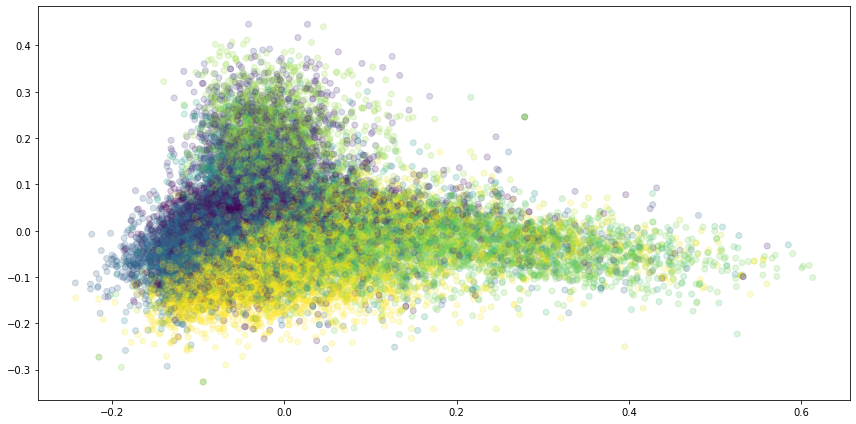

In [13]:
cuisines = list(set(y_train))
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(Xpca[:,0], Xpca[:,1], c=[cuisines.index(c) for c in y_train], alpha=.2)
plt.tight_layout()
plt.show()

## Test classifiers

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from bornrule import BornClassifier

In [15]:
classifiers = {
    'RAF': RandomForestClassifier(), 'LOR': LogisticRegression(max_iter=500), 'MNB': MultinomialNB(), 
    'SVC': SVC(), 'KNN': KNeighborsClassifier(), 'BORN': BornClassifier()
}

### Training

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
X_train_s = X_train
X_test_s = X_test 

In [18]:
run = [(cname, cls) for cname, cls in classifiers.items()]
for cname, cls in tqdm(run):
    cls.fit(X_train_s, y_train)

  0%|          | 0/6 [00:00<?, ?it/s]

### Evaluation

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [20]:
predictions = {}
for cname, cls in tqdm(run):
    predictions[cname] = cls.predict(X_test_s)

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
results = {}
for cname, y_pred in predictions.items():
    clr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    w = clr['weighted avg']
    m = clr['macro avg']
    results[cname] = {
        'w_precision': w['precision'], 'w_recall': w['recall'], 'w_f1': w['f1-score'],
        'm_precision': m['precision'], 'm_recall': m['recall'], 'm_f1': m['f1-score'],
    }
R = pd.DataFrame(results).T

In [22]:
R.sort_values('w_f1', ascending=False)

,w_precision,w_recall,w_f1,m_precision,m_recall,m_f1
SVC,0.789414,0.781979,0.774857,0.805834,0.649203,0.703675
LOR,0.775100,0.773431,0.765906,0.770260,0.638659,0.686012
BORN,0.751124,0.701629,0.713408,0.596117,0.674731,0.617502
RAF,0.711109,0.702534,0.683599,0.736433,0.526305,0.582551
MNB,0.735110,0.696802,0.663404,0.806578,0.467095,0.512749
KNN,0.707995,0.322808,0.353362,0.702931,0.232773,0.293333


## Explanation

In [23]:
born = classifiers['BORN']

### Global

In [24]:
global_e = pd.DataFrame(born.explain().toarray(), columns=born.classes_, index=vectorizer.get_feature_names_out())

In [25]:
global_e['italian'].sort_values(ascending=False).head(10)

grated parmesan cheese        0.058491
marinara sauce                0.055084
ricotta cheese                0.046516
shredded mozzarella cheese    0.045819
arborio rice                  0.044631
fresh mozzarella              0.043764
pecorino romano cheese        0.041669
prosciutto                    0.041038
pesto                         0.040324
lasagna noodles               0.040116
Name: italian, dtype: float64

### Local

In [26]:
local_docs = [['dry white wine', 'unsalted butter'], ['salt', 'rice vinegar', 'pesto', 'extra-virgin olive oil']]
local = vectorizer.transform(local_docs)

In [27]:
P = pd.DataFrame(born.predict_proba(local), columns=born.classes_).T

In [28]:
P.sort_values(1, ascending=False)

,0,1
italian,0.129858,0.225192
japanese,0.009298,0.151120
greek,0.059800,0.096249
korean,0.003006,0.095035
chinese,0.010860,0.093658
vietnamese,0.007281,0.086589
spanish,0.098497,0.056736
thai,0.008814,0.056255
french,0.228926,0.039329
moroccan,0.032381,0.021811


In [29]:
E = pd.DataFrame(born.explain(X=local).toarray(), columns=born.classes_, index=vectorizer.get_feature_names_out())

In [30]:
E['italian'].sort_values(ascending=False).head(10)

pesto                     0.025699
dry white wine            0.017645
extra-virgin olive oil    0.014671
unsalted butter           0.009120
rice vinegar              0.002161
salt                      0.000633
peach nectar              0.000000
pepper flakes             0.000000
penne                     0.000000
penne pasta               0.000000
Name: italian, dtype: float64

In [31]:
E['japanese'].sort_values(ascending=False).head(10)

rice vinegar              0.030563
extra-virgin olive oil    0.004276
unsalted butter           0.004271
dry white wine            0.002891
salt                      0.000520
pepper                    0.000000
peeled tomatoes           0.000000
penne                     0.000000
penne pasta               0.000000
penne rigate              0.000000
Name: japanese, dtype: float64